In [143]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import statsmodels as sm
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.preprocessing import OneHotEncoder
import tweedie
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pygraphviz
#warnings.filterwarnings(action='ignore', category=UserWarning)
from xgboost import plot_tree
from sklearn.utils import class_weight
import optuna as op


In [144]:

class train_validate_n_test(object):

    def __init__(self) -> None:    
        dataset_filename = "xgboost_feat_train_ds_all_stns.csv"
        full_set = pd.read_csv(dataset_filename,parse_dates=['dt_ts'])
        full_set = full_set.drop(['Unnamed: 0'],axis=1)

        self.train_stop_time_fold_1 = '2021/11/30 00:00'
        self.val_stop_time_fold_1 = '2021/12/05 00:00'
        self.train_stop_time_fold_2 = self.val_stop_time_fold_1
        self.val_stop_time_fold_2 = '2021/12/10 00:00'
        self.train_stop_time_fold_3 = self.val_stop_time_fold_2
        self.val_stop_time_fold_3 = '2021/12/16 00:00'

        self.classes_weights = self.analyze_target(full_set)
        self.full_set = self.onehotencode_cat_var(full_set)


    def analyze_target(self,full_set):
        print('###################################### TARGET data EXPLORATION ###########################################')
        print('Target class frequency:')
        print(full_set['target'].value_counts())

        full_set['target'].hist()
        plt.title('Target histogram')
        plt.xlabel('demand value (class)')
        plt.ylabel('count')
        plt.show()

        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=full_set['target'])
        print('\nTarget class weights:')
        print(np.unique(classes_weights))
        print('##########################################################################################################')
        return classes_weights


    def onehotencode_cat_var(self,full_set):
        full_set = full_set.astype({"stn_id":str,"block_id":str,"ts_of_day":str,"hr_of_day":str,"day_of_wk":str,"day_of_mn":str,"wk_of_mon":str })
        full_set = pd.get_dummies(full_set, prefix_sep="_",columns =["stn_id","block_id","ts_of_day","hr_of_day","day_of_wk","day_of_mn","wk_of_mon"],drop_first=True)
        #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)
        return full_set


    def walk_forward_val_n_train_set(self,fold):
        # split validation set into 3 parts
        if (fold==1):
            train1 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_1]
            tr1 = train1.drop(["target","dt_ts"], axis=1)
            label_train1 = pd.DataFrame(train1["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train1)
            dtrain1 = xgb.DMatrix(tr1, label=label_train1,weight=classes_weights)

            val1 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_1) & (self.full_set['dt_ts'] < self.val_stop_time_fold_1)]
            v1 = val1.drop(["target","dt_ts"], axis=1)
            label_val1 = pd.DataFrame(val1["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val1)
            dval1 = xgb.DMatrix(v1, label=label_val1,weight=classes_weights)
            return dtrain1, dval1
        
        elif (fold==2):
            train2 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_2]
            tr2 = train2.drop(["target","dt_ts"], axis=1)
            label_train2 = pd.DataFrame(train2["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train2)
            dtrain2 = xgb.DMatrix(tr2, label=label_train2,weight=classes_weights)
            val2 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_2) & (self.full_set['dt_ts'] < self.val_stop_time_fold_2)]
            v2 = val2.drop(["target","dt_ts"], axis=1)
            label_val2 = pd.DataFrame(val2["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val2)
            dval2 = xgb.DMatrix(v2, label=label_val2,weight=classes_weights)
            return dtrain2,dval2
        
        else:
            train3 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_3]
            tr3 = train3.drop(["target","dt_ts"], axis=1)
            label_train3 = pd.DataFrame(train3["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train3)
            dtrain3 = xgb.DMatrix(tr3, label=label_train3,weight=classes_weights)
            val3 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_3) & (self.full_set['dt_ts'] < self.val_stop_time_fold_3)]
            v3 = val3.drop(["target","dt_ts"], axis=1)
            label_val3 = pd.DataFrame(val3["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val3)
            dval3 = xgb.DMatrix(v3, label=label_val3,weight=classes_weights)
            return dtrain3,dval3



    def xgb_train_validate(self,params,num_round, e_s_r,t_v_p):
        dtrain1, dval1 = self.walk_forward_val_n_train_set(fold=1)
        watchlist1  = [(dtrain1,'train1_tweedie_loss'), (dval1, 'val1_tweedie_loss')]
        evals_result1 = {}
        model1 = xgb.train(params=params, dtrain=dtrain1, num_boost_round=num_round, evals=watchlist1, evals_result=evals_result1,  early_stopping_rounds=e_s_r,verbose_eval=False)
        val1_error = evals_result1['val1_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        dtrain2, dval2 = self.walk_forward_val_n_train_set(fold=2)
        watchlist2  = [(dtrain2,'train2_tweedie_loss'), (dval2, 'val2_tweedie_loss')]
        evals_result2 = {}
        model2 = xgb.train(params=params, dtrain=dtrain2, num_boost_round=num_round, evals=watchlist2, evals_result=evals_result2, early_stopping_rounds=e_s_r,xgb_model=model1,verbose_eval=False )
        val2_error = evals_result2['val2_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        dtrain3, dval3 = self.walk_forward_val_n_train_set(fold=3)
        watchlist3  = [(dtrain3,'train3_tweedie_loss'), (dval3, 'val3_tweedie_loss')]
        evals_result3 = {}
        self.model3 = xgb.train(params=params, dtrain=dtrain3, num_boost_round=num_round, evals=watchlist3, evals_result=evals_result3, early_stopping_rounds=e_s_r,xgb_model=model2,verbose_eval=False )
        val3_error = evals_result3['val3_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        print('\n')
        print('###################################### VALIDATION Loss ###########################################')
        print('Last estimator val1_error',val1_error[-1]) # Result is a list of validation loss from each of boosters/estimators, last one is final val loss.
        print('Last estimator val2_error',val2_error[-1])
        print('Last estimator val3_error',val3_error[-1])

        val_avg_error = np.mean(np.array([val1_error[-1],val2_error[-1],val3_error[-1]]))
        print('val_avg_error',val_avg_error)
        print('##################################################################################################')
        return val_avg_error


    def display_tweedie_plot(self,):
        tvs = tweedie.tweedie(mu=1, p=1.1, phi=1.5).rvs(6000)
        sn.set(rc={'figure.figsize':(10,5)})
        # plt.figure(figsize=(25,10))
        sn.displot(tvs)
        plt.title('Parametric tweedie distribution')
        plt.xlabel('demand value (class)')
        plt.show()
        return


    def evaluate_predictions(self,):
        test = self.full_set.loc[self.full_set['dt_ts'] > self.val_stop_time_fold_3]
        X_test = test.drop(["target","dt_ts"], axis=1)
        label_test = pd.DataFrame(test["target"])
        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_test)
        dtest = xgb.DMatrix(X_test, label=label_test,weight=classes_weights)

        preds = self.model3.predict(dtest)
        preds = np.rint(preds)
        label_test = label_test['target'].to_numpy()

        print('####################################### PREDICTION #################################################')    
        plt.plot(preds,'*')
        plt.ylabel('Demand value (prediction)')
        plt.xlabel('Time')     
        plt.show()
        plt.plot(label_test,'*')
        plt.ylabel('Demand value (Ground-truth)')
        plt.xlabel('Time')     
        plt.show()
        # plt.plot(label_test[40:60],'*')
        # plt.title('zoomed true label test')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()
        # plt.plot(preds[40:60],'*')
        # plt.title('zoomed pred label')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()

        #"use confusion matrix, ROC, F1 scores to evaluate"
        cm = confusion_matrix(label_test,preds)
        max_classes = max(len(np.unique(label_test)),len(np.unique(preds)))
        df_cm = pd.DataFrame(cm, index = [i for i in range(max_classes)],
                        columns = [i for i in range(max_classes)])
        plt.figure(figsize = (10,7))      
        s = sn.heatmap(df_cm, annot=True, )
        s.set(xlabel='Predicted-Label', ylabel='True-Label')
        print('##################################################################################################')

        return X_test,label_test, preds


    def identify_tweedie_variance_param():
        #TODO:#"fit on data"
        # follow this tutorial https://notebook.community/thequackdaddy/tweedie/example/tweedie_demo
        # GLM.estimate_tweedie_power()
        # #Training model
        # tweedie_model = sm.GLM(y_train, X_train, exposure = df_train.exposure, family=sm.families.Tweedie(link=None,var_power=1.5,eql=True))
        # tweedie_result = tweedie_model.fit()
        # #Using the initial model output to decide the optimum index parameter "p"
        # GLM.estimate_tweedie_power(training_result, method='brentq', low=1.01, high=5.0)
        # tweedie_model.estimate_tweedie_power(tweedie_result.mu, method='brentq', low=1.01, high=5.0)
        return


    def make_predictions(self,):
        #TODO:#for new predictions after tuning model

        return
    

    def visualize_tree(self,):
        #TODO:#"draw out a few trees to interpret results"        
        #xgb.plot_tree(self.train3)
        plot_tree(self.model3)

        return


    def optuna_hp_opt(self,):


        return



###################################### TARGET data EXPLORATION ###########################################
Target class frequency:
0    37657
1     2348
2      179
3       15
4        1
Name: target, dtype: int64


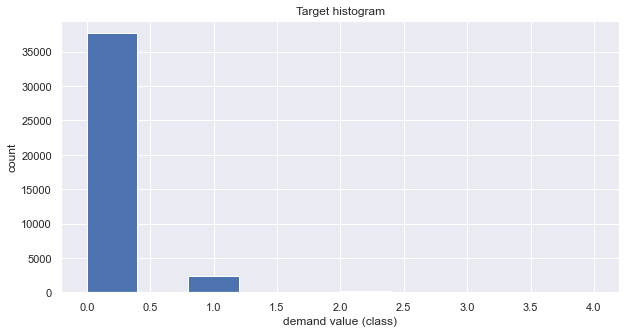


Target class weights:
[2.13506121e-01 3.42419080e+00 4.49162011e+01 5.36000000e+02
 8.04000000e+03]
##########################################################################################################


###################################### VALIDATION Loss ###########################################
Last estimator val1_error 15.881628
Last estimator val2_error 10.970417
Last estimator val3_error 15.870056
val_avg_error 14.240700333333331
##################################################################################################


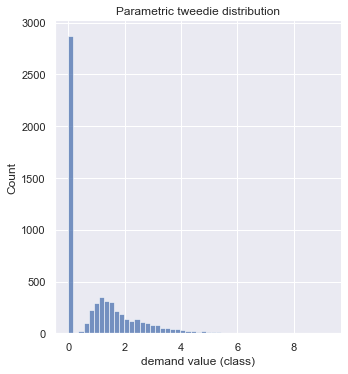

####################################### PREDICTION #################################################


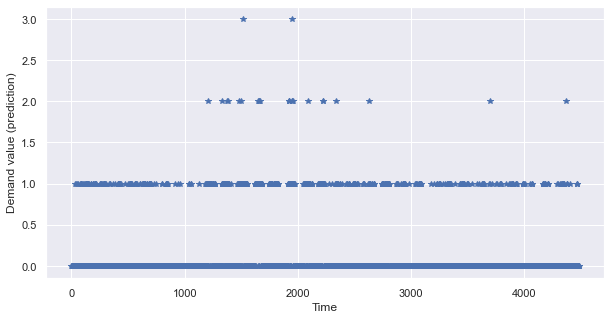

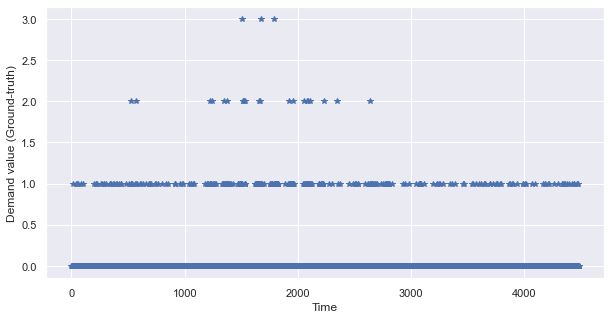

##################################################################################################


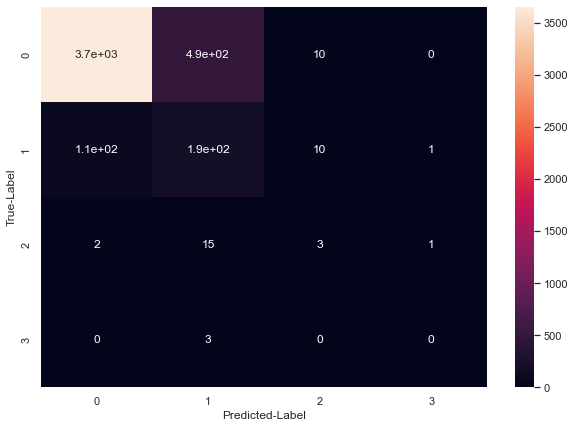

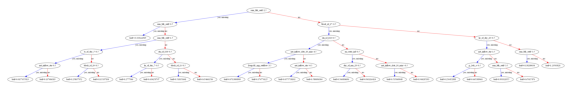

In [145]:
if __name__ == "__main__":
    os.chdir("c:\Work\WORK_PACKAGE\Demand_forecasting\BLUESG_Demand_data\Data-preprocessing_data_generation")
    t_v_t = train_validate_n_test()
    
    ######  SET Hyperparameter's range for tuning ######
    early_stopping_rounds = 100
    tweedie_variance_power = 1.1 #t_v.identify_tweedie_variance_param()
    eval_metric = 'tweedie-nloglik@'+str(tweedie_variance_power)
    num_round= 1000
    max_depth= 5
    eta=0.3
    subsample=1.0
    colsample_bytree=1.0
    objective= 'reg:tweedie'
    ######  SET Hyperparameter's range for tuning ######


    # Hyperparameters and algorithm parameters are described here
    params = {"max_depth": max_depth,
            "eta": eta,
            "objective": objective,
            "subsample" : subsample,
            "colsample_bytree":colsample_bytree,
            'eval_metric':eval_metric, ## try using AUC as well.. 
            'tweedie_variance_power': tweedie_variance_power,
            'gamma': 0.05,
            'reg_alpha': 0, 
            'reg_lambda':1,
            'min_child_weight':1,

            }


    val_avg_error = t_v_t.xgb_train_validate(params,num_round, early_stopping_rounds,tweedie_variance_power)

    t_v_t.display_tweedie_plot() # compare the graphs from target histogram and this function to choose tweedie_variance_power 

    X_test,label_test, preds = t_v_t.evaluate_predictions()

    t_v_t.visualize_tree()
    # print('\n',"tweedie_variance_power ",tweedie_variance_power,'\n')





